In [4]:
#importing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('ModelForecast.csv')
data.head()

,Date,Transactions
0,01/06/2022,2100
1,02/06/2022,1872
2,03/06/2022,2431
3,04/06/2022,2389
4,05/06/2022,1655


In [5]:
data['Date']=pd.to_datetime(data.Date, dayfirst=True, format="%d/%m/%Y") 
data_index=data.copy()
data_index.set_index('Date',inplace=True)
data_index.head()

,Transactions
Date,
2022-06-01,2100
2022-06-02,1872
2022-06-03,2431
2022-06-04,2389
2022-06-05,1655


In [23]:
total_transactions=data_index.resample('d').sum()
total_transactions.head()

,Transactions
Date,
2022-06-01,2100
2022-06-02,1872
2022-06-03,2431
2022-06-04,2389
2022-06-05,1655


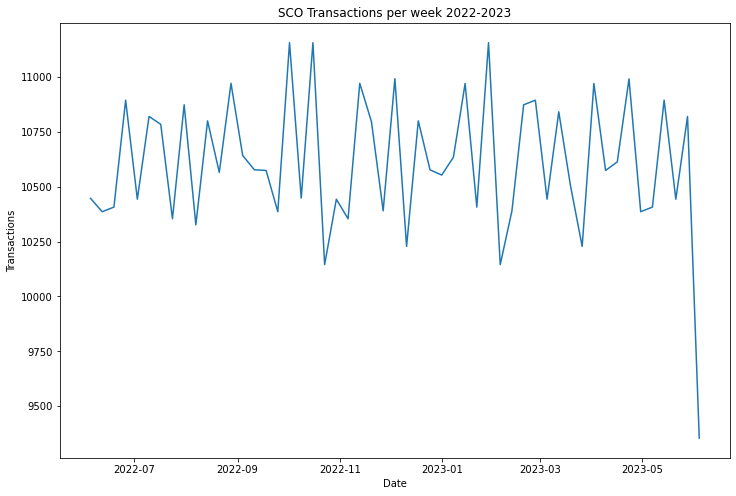

In [9]:
fig, ax = plt.subplots(figsize=(12,8)) 
ax.plot(total_transactions.index,total_transactions.Transactions) 
ax.set_title('SCO Transactions per week 2022-2023')
ax.set_ylabel('Transactions')
ax.set_xlabel('Date')
plt.show()

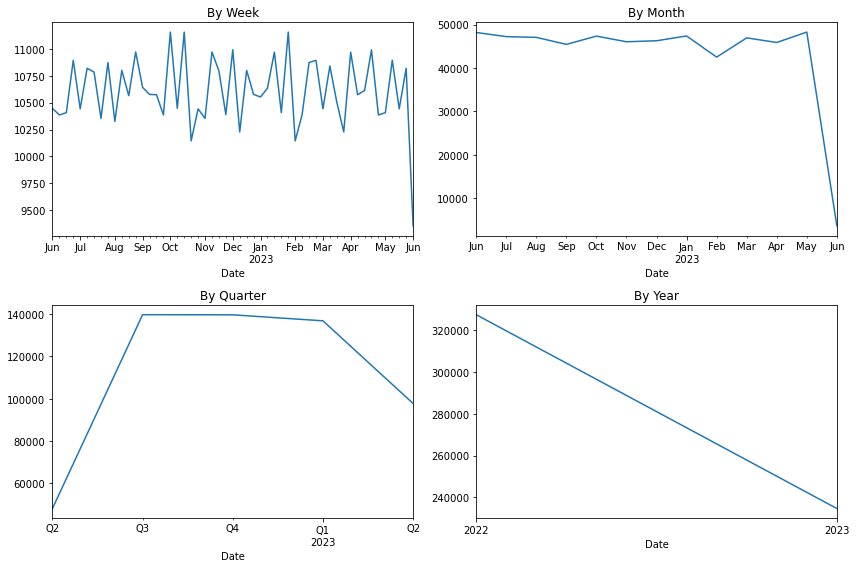

In [11]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8))
total_transactions.Transactions.resample('w').sum().plot(ax=ax[0,0]) # group by week
total_transactions.Transactions.resample('m').sum().plot(ax=ax[0,1]) # group by month
total_transactions.Transactions.resample('q').sum().plot(ax=ax[1,0]) # group by quarter
total_transactions.Transactions.resample('a').sum().plot(ax=ax[1,1]) # group by year
ax[0,0].set_title('By Week')
ax[0,1].set_title('By Month')
ax[1,0].set_title('By Quarter')
ax[1,1].set_title('By Year')
fig.tight_layout()
plt.show()

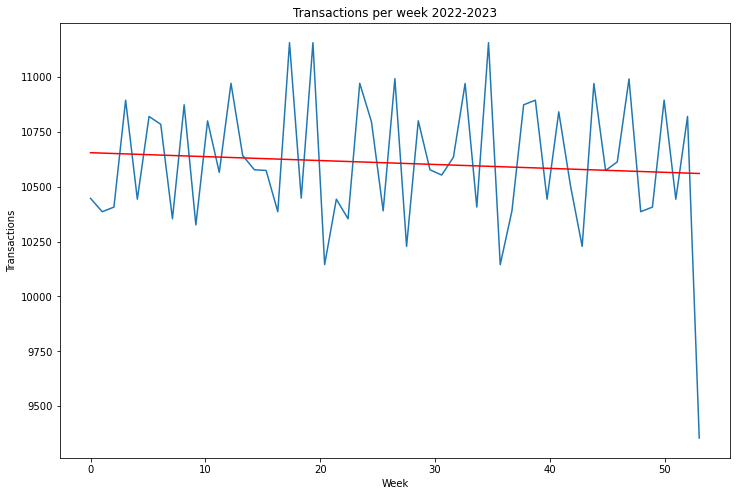

In [12]:
transactions_by_week=total_transactions.resample('w').sum() # creating a dataframe which shows the total loss value by week

data_points=np.linspace(0,len(transactions_by_week),num=len(transactions_by_week)) # list of data points as long as dataframe

line_coef = np.polyfit(data_points,transactions_by_week.Transactions,1) # Identifying the trendline of the weekly loss due to shrink data

polynomial = np.poly1d(line_coef) # Function that for any independent variable given, will return the dependent variable

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data_points,transactions_by_week.Transactions)
ax.plot(data_points, polynomial(data_points),c='red')
ax.set_title('Transactions per week 2022-2023')
ax.set_ylabel('Transactions')
ax.set_xlabel('Week')
plt.show()

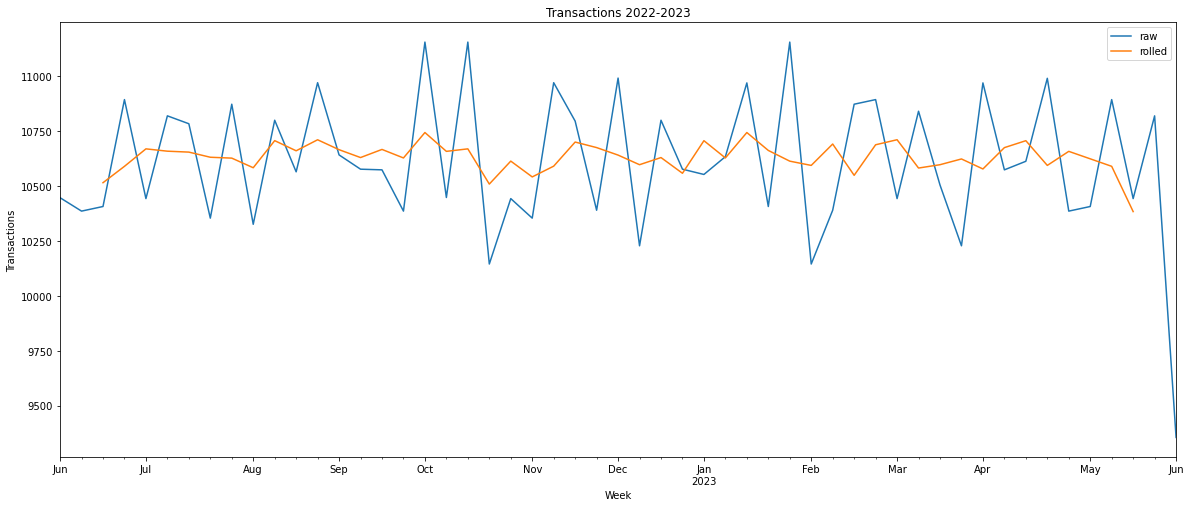

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
total_transactions.Transactions.plot(ax=ax,label='raw')
total_transactions.rolling(window=5, center= True).mean()['Transactions'].plot(ax=ax,label='rolled')
ax.set_title('Transactions 2022-2023')
ax.set_ylabel('Transactions')
ax.set_xlabel('Week')
plt.legend()
plt.show()

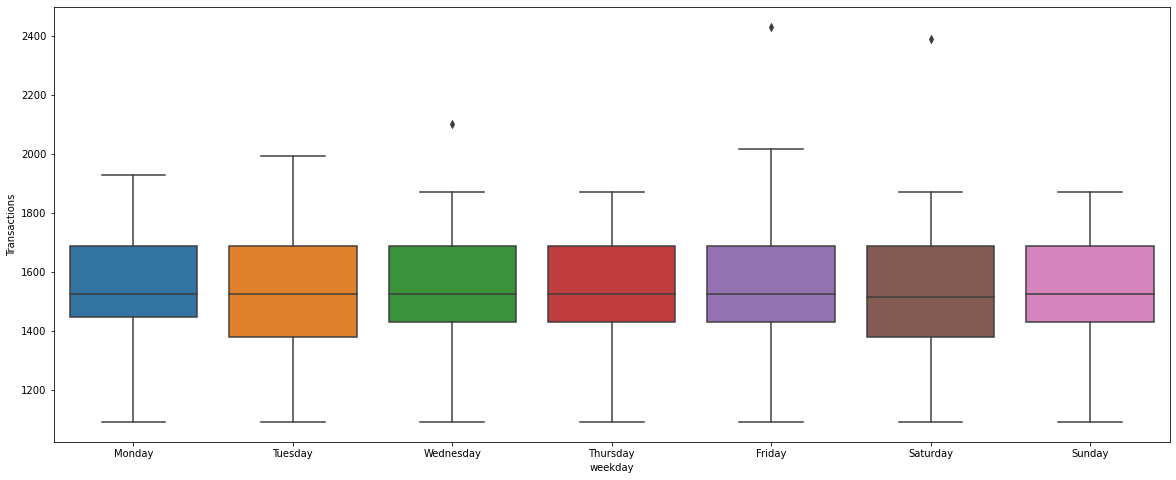

In [24]:
#identifying which DOTW has the highest store traffic

import seaborn as sns

total_transactions['weekday']=total_transactions.index.day_name()

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(x='weekday',y='Transactions',data=total_transactions,ax=ax,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

C:\Users\ab185568\AppData\Local\Temp\ipykernel_15880\2004250289.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test=transactions_by_week['2023'] # create test dataset


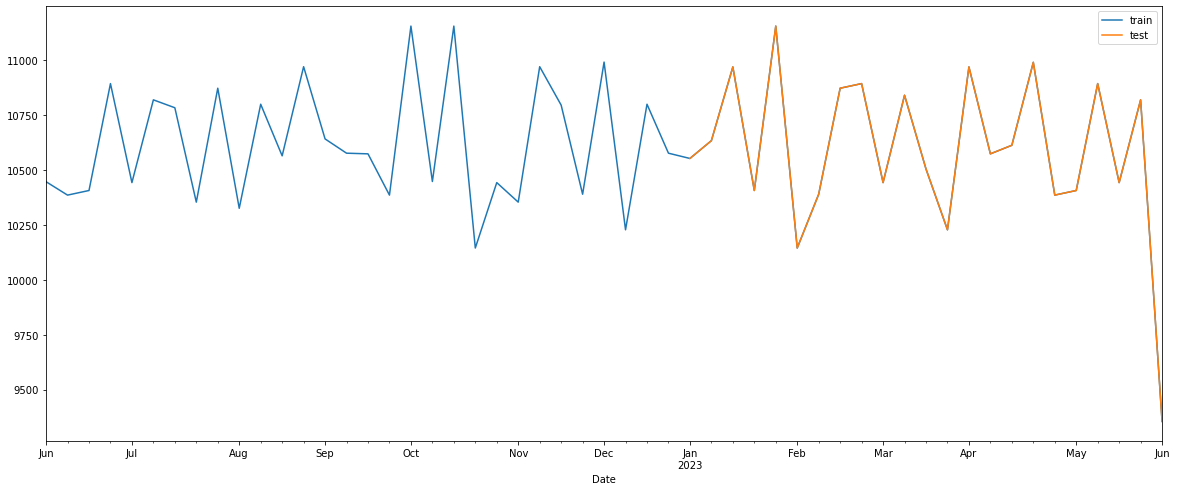

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

train=transactions_by_week['2022':'2023'] # create training dataset
test=transactions_by_week['2023'] # create test dataset

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test.Transactions.plot(ax=ax,label='test')
plt.legend()
plt.show()

C:\Users\ab185568\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


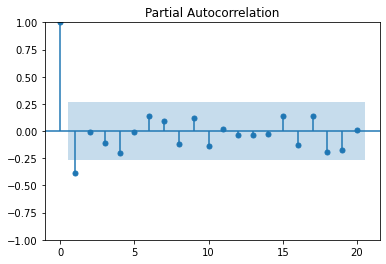

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train.Transactions,lags=20) 
plt.show()

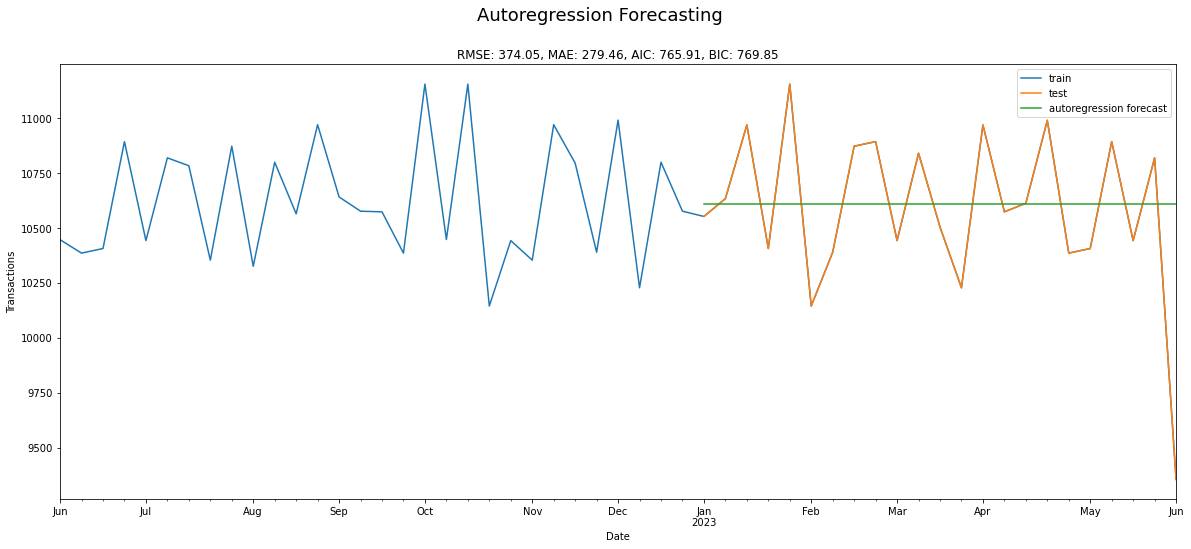

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# create AutoReg model with 0 lags
ar = AutoReg(train.Transactions,lags=0).fit()

test_ar=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ar['predicted']=ar.predict(start=test_ar.index[0],end=test_ar.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ar=round(np.sqrt(mean_squared_error(test_ar.Transactions,test_ar.predicted)),2)
mae_ar=round(mean_absolute_error(test_ar.Transactions,test_ar.predicted),2)
aic_ar=round(ar.aic,2)
bic_ar=round(ar.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test_ar.Transactions.plot(ax=ax,label='test')
test_ar.predicted.plot(ax=ax,label='autoregression forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ar)+', MAE: '+str(mae_ar)+', AIC: '+str(aic_ar)+', BIC: '+str(bic_ar))
plt.suptitle("Autoregression Forecasting",fontsize=18)
plt.ylabel('Transactions')
plt.show()

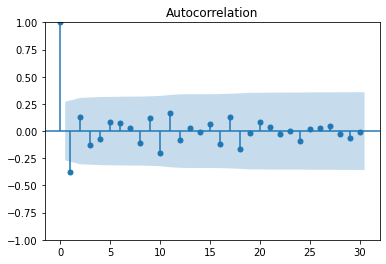

In [20]:
#moving average
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train.Transactions,lags=30) 
plt.show()

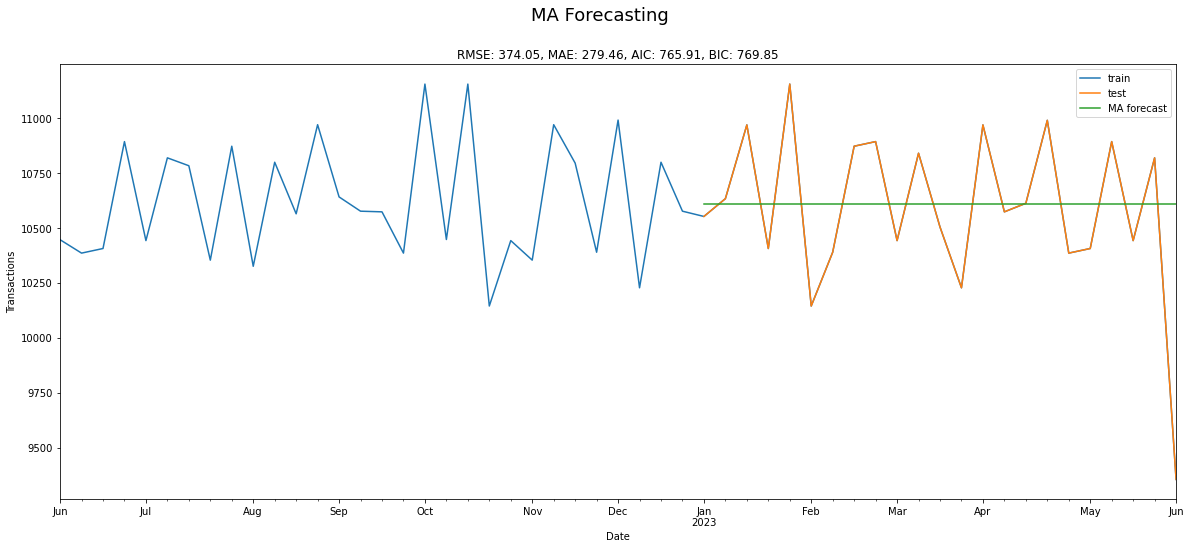

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# create MA model with order 0
ma = ARIMA(train.Transactions,order=(0,0,0)).fit()

test_ma=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ma['predicted']=ma.predict(start=test_ma.index[0],end=test_ma.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ma=round(np.sqrt(mean_squared_error(test_ma.Transactions,test_ma.predicted)),2)
mae_ma=round(mean_absolute_error(test_ma.Transactions,test_ma.predicted),2)
aic_ma=round(ma.aic,2)
bic_ma=round(ma.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test_ma.Transactions.plot(ax=ax,label='test')
test_ma.predicted.plot(ax=ax,label='MA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ma)+', MAE: '+str(mae_ma)+', AIC: '+str(aic_ma)+', BIC: '+str(bic_ma))
plt.suptitle("MA Forecasting",fontsize=18)
plt.ylabel('Transactions')
plt.show()

C:\Users\ab185568\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


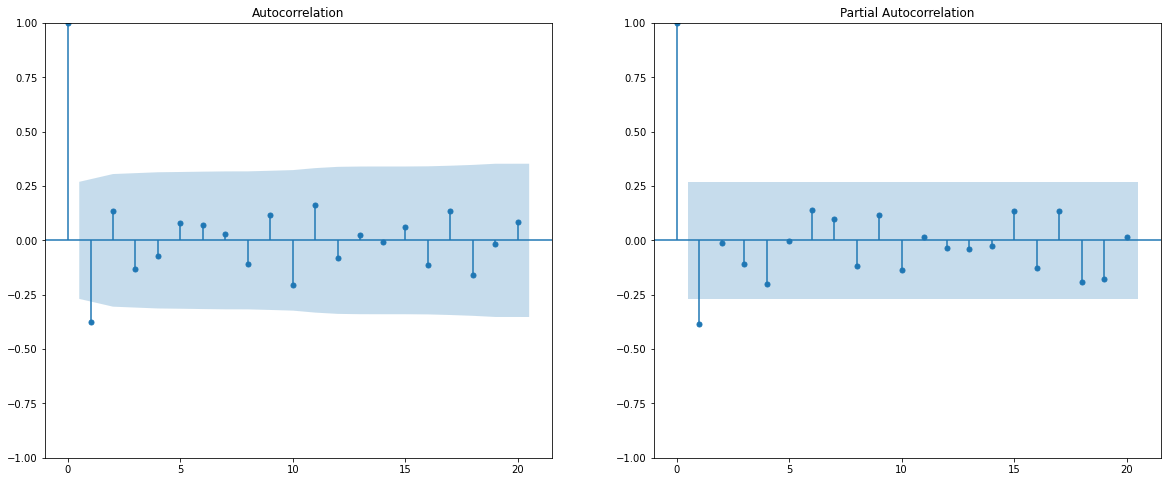

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.Transactions,lags=20,ax=ax[0]) 
plot_pacf(train.Transactions,lags=20,ax=ax[1]) 
plt.show()

In [25]:
#I will be performing ARIMA model starting with stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(train.Transactions)
print('p-value:' +str(result[0]))

p-value:-4.967357551479397


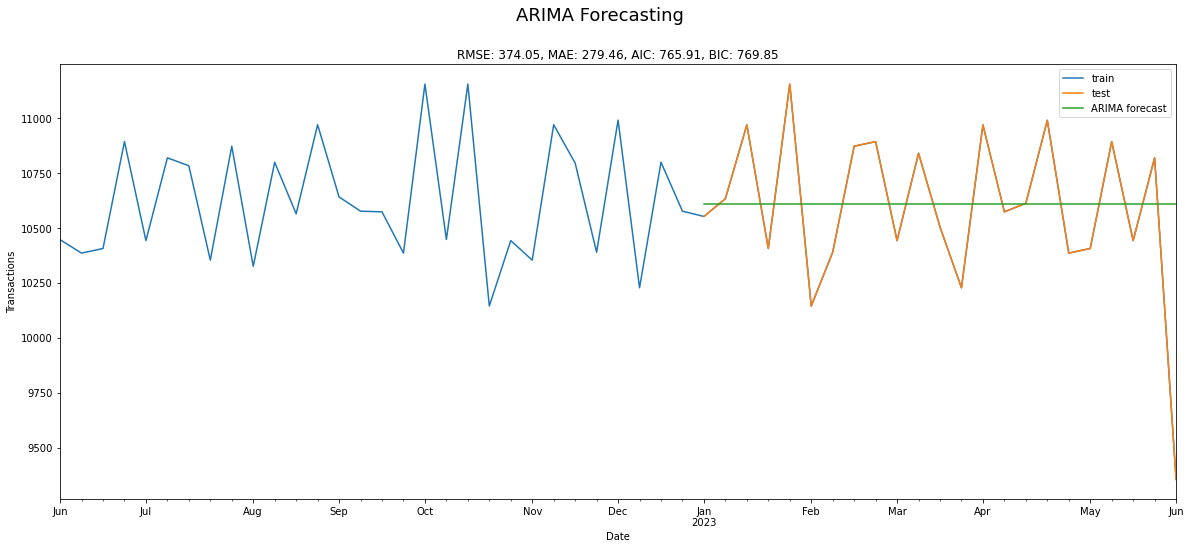

In [26]:
# create ARIMA model with best order
arima = ARIMA(train.Transactions,order=(0,0,0)).fit()

test_arima=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_arima['predicted']=arima.predict(start=test_arima.index[0],end=test_arima.index[-1]) 

# calculate errors and round to 2 d.p
rmse_arima=round(np.sqrt(mean_squared_error(test_arima.Transactions,test_arima.predicted)),2)
mae_arima=round(mean_absolute_error(test_arima.Transactions,test_arima.predicted),2)
aic_arima=round(arima.aic,2)
bic_arima=round(arima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test_arima.Transactions.plot(ax=ax,label='test')
test_arima.predicted.plot(ax=ax,label='ARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_arima)+', MAE: '+str(mae_arima)+', AIC: '+str(aic_arima)+', BIC: '+str(bic_arima))
plt.suptitle("ARIMA Forecasting",fontsize=18)
plt.ylabel('Transactions')
plt.show()

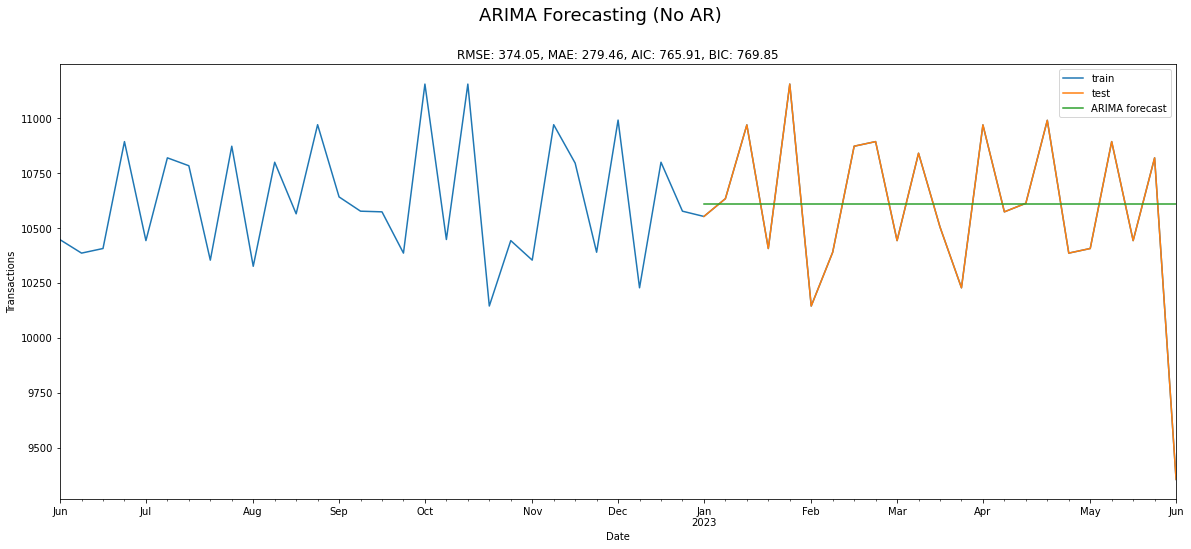

In [28]:
arima_no_AR = ARIMA(train.Transactions,order=(0,0,0)).fit()

test_arima_no_AR=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_arima_no_AR['predicted']=arima_no_AR.predict(start=test_arima_no_AR.index[0],end=test_arima_no_AR.index[-1]) 

# calculate errors and round to 2 d.p
rmse_arima_no_AR=round(np.sqrt(mean_squared_error(test_arima_no_AR.Transactions,test_arima_no_AR.predicted)),2)
mae_arima_no_AR=round(mean_absolute_error(test_arima_no_AR.Transactions,test_arima_no_AR.predicted),2)
aic_arima_no_AR=round(arima_no_AR.aic,2)
bic_arima_no_AR=round(arima_no_AR.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test_arima_no_AR.Transactions.plot(ax=ax,label='test')
test_arima_no_AR.predicted.plot(ax=ax,label='ARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_arima_no_AR)+', MAE: '+str(mae_arima_no_AR)+', AIC: '+str(aic_arima_no_AR)+', BIC: '+str(bic_arima_no_AR))
plt.suptitle("ARIMA Forecasting (No AR)",fontsize=18)
plt.ylabel('Transactions')
plt.show()

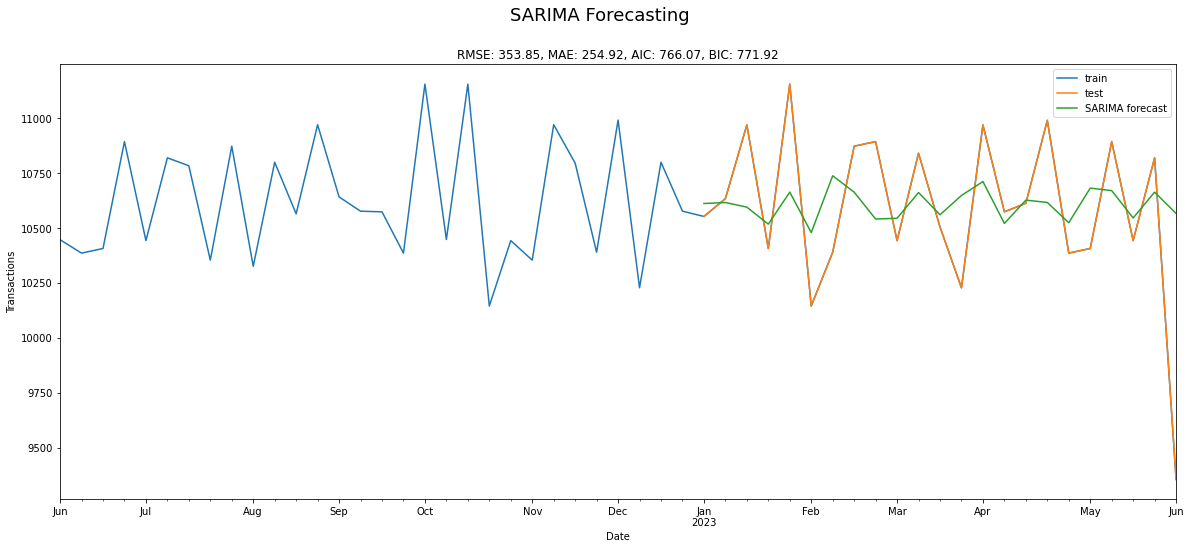

In [30]:
# create SARIMA model with best order and best seasonal_order
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train.Transactions,order=(1,1,1),seasonal_order=(0,0,0,52)).fit()

test_sarima=test.copy() # create test set for this example

test_sarima['predicted']=sarima.predict(start=test_sarima.index[0],end=test_sarima.index[-1])

rmse_sarima=round(np.sqrt(mean_squared_error(test_sarima.Transactions,test_sarima.predicted)),2)
mae_sarima=round(mean_absolute_error(test_sarima.Transactions,test_sarima.predicted),2)
aic_sarima=round(sarima.aic,2)
bic_sarima=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test_sarima.Transactions.plot(ax=ax,label='test')
test_sarima.predicted.plot(ax=ax,label='SARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarima)+', MAE: '+str(mae_sarima)+', AIC: '+str(aic_sarima)+', BIC: '+str(bic_sarima))
plt.suptitle("SARIMA Forecasting",fontsize=18)
plt.ylabel('Transactions')
plt.show()

C:\Users\ab185568\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


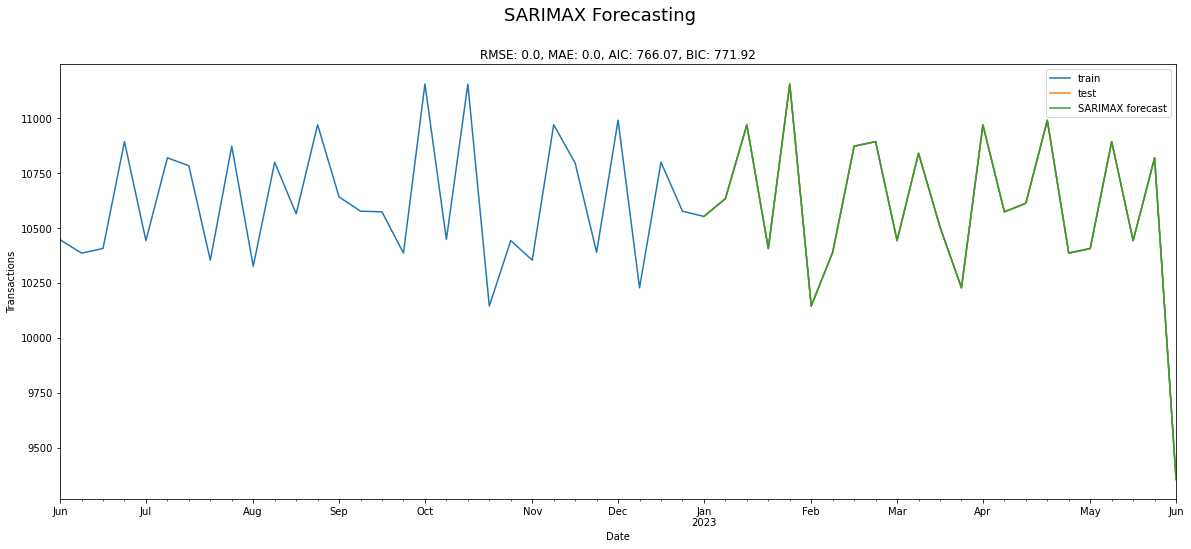

In [32]:
sarimax = SARIMAX(train.Transactions,exog=train.Transactions,order=(0,0,0),seasonal_order=(0,0,0,52)).fit()

test_sarimax=test.copy() 

test_sarimax['predicted']=sarimax.predict(start=test_sarimax.index[0],end=test_sarimax.index[-1],exog=test_sarimax.Transactions) 

# calculate errors and round to 2 d.p
rmse_sarimax=round(np.sqrt(mean_squared_error(test_sarimax.Transactions,test_sarimax.predicted)),2)
mae_sarimax=round(mean_absolute_error(test_sarimax.Transactions,test_sarimax.predicted),2)
aic_sarimax=round(sarima.aic,2)
bic_sarimax=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Transactions.plot(ax=ax,label='train')
test_sarimax.Transactions.plot(ax=ax,label='test')
test_sarimax.predicted.plot(ax=ax,label='SARIMAX forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarimax)+', MAE: '+str(mae_sarimax)+', AIC: '+str(aic_sarimax)+', BIC: '+str(bic_sarimax))
plt.suptitle("SARIMAX Forecasting",fontsize=18)
plt.ylabel('Transactions')
plt.show()


In [33]:
auto_metrics=pd.DataFrame({'Model':['AR','MA','ARIMA','SARIMA','SARIMAX'],
                           'RMSE':[rmse_ar,rmse_ma,rmse_arima,rmse_sarima,rmse_sarimax],
                           'MAE':[mae_ar,mae_ma,mae_arima,mae_sarima,mae_sarimax],
                           'AIC':[aic_ar,aic_ma,aic_arima,aic_sarima,aic_sarimax],
                           'BIC':[bic_ar,bic_ma,bic_arima,bic_sarima,bic_sarimax]})
auto_metrics

,Model,RMSE,MAE,AIC,BIC
0,AR,374.05,279.46,765.91,769.85
1,MA,374.05,279.46,765.91,769.85
2,ARIMA,374.05,279.46,765.91,769.85
3,SARIMA,353.85,254.92,766.07,771.92
4,SARIMAX,0.00,0.00,766.07,771.92
